# Data Cleaning and EDA

This notebook contains all our data cleaning and EDA work for the project. 

## Data Dictionary
Defined below are some of the terms important to understanding our datasets and why we cleaned them the way we did. 

Date - YYYY-MM-DD
Team - Team the player played on at the time of injury




Glossary - sourced largely from https://en.wikipedia.org/wiki/Injured_list
Specifics about how the NBA Inactive list works sourced from https://en.wikipedia.org/wiki/Injured_reserve_list

DTD - "Day-to-day" - injury; minor injury

IL - Inactive list - players are placed on this list when they're injured "enough" to take them out of at least one game - this means at least a moderate injury

DNP - Did not play - indicates that a player did not play in a particular game due to injury, but was not placed on IL. indicates minor injury.

Indefinitely - as dictionary - indicates that the severity of an injury is such that a player will have to miss at least one, or potentially several, games. Also suggests an injury that is at least moderate

ACL - anterior cruciate ligament - an extremely severe injury

Achilles - Achilles tendon - also a severe injury which will leave players out for several games

## NBA Common info 

NBA seasons typically run from October to June, so we will set our season to be from August-August



# Initial EDA on Injury Dataset
These were our initial explorations of the dataset in its raw form. 

In [1]:
#setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

In [2]:
#read injury data from csv
url = "https://raw.githubusercontent.com/COGS118A/Group014-Wi23/main/injuries_2010-2020.csv"
injuries = pd.read_csv(url)
injuries.head()

,Date,Team,Acquired,Relinquished,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)


In [3]:
injuries.shape #(27105, 5)

(27105, 5)

In [4]:
#Number of non "NaN" entries in acquired column
injuries[injuries['Acquired'].apply(lambda x: isinstance(x, str))].shape #(9452, 5)
#Number of non "NaN" entries in Relinquished column
injuries[injuries['Relinquished'].apply(lambda x: isinstance(x, str))].shape #(17560, 5)

#NOTE: The NaN entries don't seem to be np.nan, but float("NaN"). This may have just been my mistake due to some idiosyncrasy
#in the way I was doing things, but if it wasn't, we'll have to be a little crafty about how we fix it. 

(17560, 5)

In [5]:
#Number of unique players we have injuries recorded for
injuries['Relinquished'].nunique() #1156
#Number of unique players who came back after injuries
injuries['Acquired'].nunique() #1111

1111

There are 27,105 rows in our original dataframe. Rows refer to a player either being acquired (9452 rows total) or relinquished (17560). There are 1156 unique players in the relinquished column, and 1111 unique players in the acquired column. Thus, some players repeat, which is to be expected since someone can be injured multiple times.

However, taking player "Jonas Jerebko" as an example (see below), we can see that we sometimes have multiple entries for the same injury (look at rows 1, 5, and 75, where 5 reports surgery to address the injury reported in 1 and 75 moves him from out indefinitely to IL as he recovers from this surgery). 

Easiest to just combine these three rows together into one entry based on the year (all of this happens in 2010), but later in 2017, he has two separate illnesses, one in January and one in March. We could get around this by rephrasing our question, or just deciding our ground truth meant that the player had been placed on IL or was out indefinitely at some point during the year, but that changes things a little bit. We'll need to make a firm decision, since I doubt we have the time to do this kind of investigation for each of 1156 unique players in the dataset. 

Also, there's no "acquired" entry after Jerebko's recovery from surgery, so we'll have to take a look at that.

In [6]:
injuries[(injuries['Relinquished'] == 'Jonas Jerebko') | (injuries['Acquired'] == 'Jonas Jerebko')]

,Date,Team,Acquired,Relinquished,Notes
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
5,2010-10-08,Pistons,NaN,Jonas Jerebko,surgery to repair torn right Achilles tendon
75,2010-10-27,Pistons,NaN,Jonas Jerebko,placed on IL recovering from surgery to repair...
15112,2016-03-16,Celtics,NaN,Jonas Jerebko,placed on IL with sore left ankle
15198,2016-03-21,Celtics,Jonas Jerebko,NaN,activated from IL
17397,2017-01-21,Celtics,NaN,Jonas Jerebko,placed on IL with illness
17455,2017-01-24,Celtics,Jonas Jerebko,NaN,activated from IL
18026,2017-03-06,Celtics,NaN,Jonas Jerebko,flu (DTD)
18051,2017-03-08,Celtics,Jonas Jerebko,NaN,returned to lineup


In [7]:
#It seemed that a lot of the acquired messages were very similar when I was scrolling. I was right.
#Most are either activated from IL or returned to lineup (~ 97 %)

injuries[injuries['Acquired'].apply(lambda x: isinstance(x, str))]['Notes'].value_counts(normalize = True)

#In cleaning, we should make them all the same, 
#except for the few that might warrant keeping distinct (ex. 'torn ACL in right knee (out for season)')

#Below I have code for checking out one such example, but I think a Google might help too.
injuries[injuries['Notes'] == 'surgery on right knee to repair torn lateral meniscus (out for season)']
injuries[(injuries['Acquired'] == 'Russell Westbrook') | (injuries['Relinquished'] == 'Russell Westbrook')]
#side note: This poor guy! 

,Date,Team,Acquired,Relinquished,Notes
7405,2013-04-26,Thunder,NaN,Russell Westbrook,torn lateral meniscus in right knee (out indef...
7413,2013-04-27,Thunder,NaN,Russell Westbrook,placed on IL with torn lateral meniscus in rig...
7414,2013-04-27,Thunder,Russell Westbrook,NaN,surgery on right knee to repair torn lateral m...
7498,2013-10-01,Thunder,NaN,Russell Westbrook,arthroscopic surgery on right knee (out indefi...
7585,2013-10-30,Thunder,NaN,Russell Westbrook,placed on IL recovering from arthroscopic surg...
7640,2013-11-03,Thunder,Russell Westbrook,NaN,activated from IL
7957,2013-11-24,Thunder,NaN,Russell Westbrook,placed on IL with knee injury
8004,2013-11-27,Thunder,Russell Westbrook,NaN,activated from IL
8480,2013-12-27,Thunder,NaN,Russell Westbrook,arthroscopic surgery on right knee (out indefi...
8482,2013-12-27,Thunder,NaN,Russell Westbrook,placed on IL recovering from arthroscopic surg...


Aside from individual players, it is good to look at teams in general because a coach's handling or training regime might have an influence on injury likelihood. Additionally, NBA teams could have moved around in the ten years we have data for, which is something important to note. 

In [8]:
#Getting bored/overwhelmed so switching focus to teams
print(injuries['Team'].value_counts())
len(injuries['Team'].value_counts())

#Bullets is sus (with only one entry)
#Bobcats end in 2013, Hornets move from New Orleans to Charlotte and New Orleans becomes Pelicans

Spurs           1163
Bucks           1068
Warriors        1060
Rockets         1058
Raptors         1044
Celtics         1040
Nets            1024
Heat            1023
Cavaliers       1001
Mavericks        992
Hawks            975
Nuggets          966
Lakers           959
Knicks           943
76ers            910
Wizards          875
Grizzlies        875
Timberwolves     860
Jazz             841
Magic            834
Pacers           831
Bulls            791
Suns             733
Kings            728
Hornets          719
Clippers         718
Thunder          717
Pistons          714
Blazers          695
Pelicans         576
Bobcats          369
Bullets            1
Name: Team, dtype: int64


32

In [9]:
injuries['Date'] = pd.to_datetime(injuries['Date']) # more chat gpt, converts the string years to a date/time object

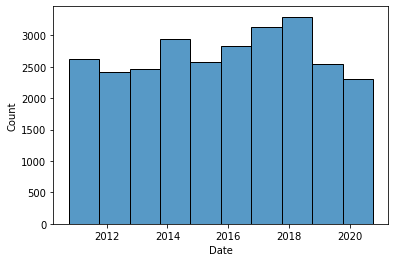

In [10]:
sns.histplot(data=injuries, x='Date', bins =10) # more chat gpt, basic EDA to see distribution of injuries
plt.show()

Does not look like there are big changes from year to year, with each year/season having in the range of 2500-3000 entries. 

# Data Cleaning

What follows is the actual data cleaning, where we get into the knitty gritty of making our dataset usable for our project. 


In [11]:
moderate_severe = ["il", "inactive list", "achilles", "acl", "fracture", "tear", "torn", "break", "fractured", "indefinitely", "broken", "surgery", "indefiinitely"] # typo in the data set 
minor = ["flu", "cold", "dtd", "dnp", "illness", "sore", "bruised", "wrist", "hyperextended"] # set up lists of strings that correlate to moderate/servere or simple issues
#returned = ["returned", "to", "lineup"]
returned = ["returned", "activated"]
out_for_season = ["out", "for", "season"]

In [12]:
def remove_punctuation(str_in):
  translation_table = str.maketrans("", "", string.punctuation + "/") # copied from chat gpt
  str_out = str_in.translate(translation_table)
  return str_out

In [13]:
def stripper(str_in=str):  # take a string, remove punctuation, set it to lower case, split it to a list of individual words
  str_in = str_in.strip()
  translation_table = str.maketrans("", "", string.punctuation + "/") # copied from chat gpt
  str_in = str_in.translate(translation_table)
  str_in = str_in.lower()
  str_in = str_in.split()
  return str_in

In [14]:
def get_season(date): # converts all year/dates to season, where 20xx represents the 20xx-20xx+1 season. Hard code for those few cases that go past the 2019 season
  season = date.year if date.month >= 9 else date.year - 1
  season = str(season)
  if season == "2020":
    season = "2019"
  return season

In [15]:
def get_name(row): #written by chat gpt, this checks Acquired and Relinquished and takes the name of whichever is not null
    if not pd.isnull(row['Acquired']):
        return row['Acquired']
    elif not pd.isnull(row['Relinquished']):
        return row['Relinquished']
    else:
        return np.nan
  

In [16]:
def ass_severity(token_list): # takes a list of tokens as input. If a severe word is found, exits returning severe. If a minor word is found,
# assigns minor and continues looking for severe. If no severe found, returns minor. If neither minor nor severe found, returns np.nan
  
  severity = "drop" # default is drop due to some coaches in team, fines, etc, which i believe were mistakenly included in the injuries dataset from Kaggle.
  # I first manually inspected the ~300 entries that weren't caught in my manual token_lists and evolved the token lists from there

  if any(["out", "for", "season"] == token_list[i:i+3] for i in range(len(token_list)-2)): #checks for the special case when notes contain "out for season" 
    return "severe" # - this is obviously a severe injury
  
  for token in token_list:
    if token in moderate_severe:
      severity = "severe"
      break
    elif token in minor:
      severity = "minor"
    elif token in returned: #checks for returned/activated, as this means the player is coming back from a previous injury and this row should be dropped
      severity = "drop"
  
  return severity

In [17]:
def get_minor(severity):
  if severity == "minor":
    return True
  else: 
    return False

In [18]:
def get_severe(severity):
  if severity == "false":
    return True
  else:
    return False

In [19]:
clean_injury = injuries
clean_injury.loc[:,'season'] = clean_injury['Date'].apply(get_season) # apply get_season
clean_injury.loc[:,'token_notes'] = clean_injury['Notes'].apply(stripper) # apply stripper
clean_injury.loc[:,'name'] = clean_injury.apply(get_name, axis=1) #apply get_name
clean_injury.loc[:,'severity'] = clean_injury['token_notes'].apply(ass_severity) #apply ass_severity
clean_injury.loc[:,'severity'].value_counts() # lil bit of EDA


severe    17532
minor      7456
drop       2117
Name: severity, dtype: int64

In [20]:
clean_injury = clean_injury[clean_injury['severity'] != 'drop'] # remove drop columns 
clean_injury['severity'].value_counts() # lil bit of EDA

severe    17532
minor      7456
Name: severity, dtype: int64

In [21]:
clean_injury = clean_injury[["season", "name", "severity"]] # filters out the relinquished/acquired now that we have the player name info, and the date now that we have the season
clean_injury.head()

,season,name,severity
0,2010,Carlos Boozer,severe
1,2010,Jonas Jerebko,severe
2,2010,Terrico White,severe
3,2010,Jeff Ayres,severe
4,2010,Troy Murphy,severe


In [22]:
clean_injury['name'].isna().sum() # some more eda
clean_injury = clean_injury.dropna() # safe as there are only 4 rows with na

In [23]:
clean_injury.loc[:,'name'] = clean_injury['name'].str.strip() #removing white space which causes problems 

In [24]:
clean_injury = clean_injury.sort_values(["season", "name"]) #sorting by season first, then name to match the nba_data

In [25]:
url_nba = "https://raw.githubusercontent.com/COGS118A/Group014-Wi23/main/AdvStats09-23.csv" #import jayson's data from the API
nba_data = pd.read_csv(url_nba)

In [26]:
nba_data.head() #Notice "AJ Price" vs. injuries "A.J. Price". Strip all punctuation? 

,Unnamed: 0,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,...,E_PACE_RANK,PACE_RANK,sp_work_PACE_RANK,PIE_RANK,FGM_RANK,FGA_RANK,FGM_PG_RANK,FGA_PG_RANK,FG_PCT_RANK,SEASON_YEAR
0,0,201985,AJ Price,AJ,1610612754,IND,24.0,50,22,28,...,176,153,153,278,270,240,253,210,408,2010
1,1,201166,Aaron Brooks,Aaron,1610612756,PHX,26.0,59,26,33,...,99,133,133,259,179,143,151,109,390,2010
2,2,201189,Aaron Gray,Aaron,1610612740,NOH,26.0,41,21,20,...,439,420,420,332,338,361,347,378,23,2010
3,3,201151,Acie Law,Acie,1610612744,GSW,26.0,51,20,31,...,136,100,100,307,305,304,326,326,264,2010
4,4,1733,Al Harrington,Al,1610612743,DEN,31.0,73,45,28,...,31,50,50,258,130,112,141,119,319,2010


In [27]:
len(set(clean_injury['name'])) #bit of eda - 1156 unique names in the injury dataset
len(set(nba_data['PLAYER_NAME'])) #bit of eda - 1595 unique names in the full nba data set - most players get some kind of injury eventually 

1595

In [28]:
nba_no_punc = nba_data.copy() # removing punctuation from both
nba_no_punc.loc[:,"PLAYER_NAME"] = nba_no_punc.loc[:,"PLAYER_NAME"].apply(remove_punctuation)
clean_injury_punc = clean_injury.copy()
clean_injury_punc.loc[:,'name'] = clean_injury_punc['name'].apply(remove_punctuation)


In [29]:
uniq_name_injury = set(clean_injury_punc['name']) # checking how we're doing
uniq_nba_name = set(nba_no_punc['PLAYER_NAME'])
overlap = uniq_nba_name.intersection(uniq_name_injury)
print(f"{len(overlap)/len(uniq_name_injury)*100}%") #94.4%, best we're going to get unfortunately. we should expect to consistently underpredict injury on new data

94.37716262975778%


In [30]:
clean_injury_punc = clean_injury_punc[clean_injury_punc['name'].isin(overlap)] # keep only those that will work in the join later on 

In [31]:
injury_join = clean_injury_punc.copy()

In [32]:
injury_join = injury_join.groupby(['season', 'name']).agg({'severity': lambda x: True if 'severe' in x.values else False})
injury_join.columns = ['severe']
injury_join['minor'] = clean_injury_punc.groupby(['season', 'name']).agg({'severity': lambda x: True if 'minor' in x.values else False})
injury_join = injury_join.reset_index()

In [33]:
injury_join = injury_join.rename(columns={'name': 'PLAYER_NAME', 'season': 'SEASON_YEAR', 'severe' : 'SEVERE_INJURY', 'minor' : 'MINOR_INJURY' })

In [34]:
injury_join.loc[:,"SEASON_YEAR"] = injury_join["SEASON_YEAR"].astype(np.int64)

In [35]:
injury_join.head()

,SEASON_YEAR,PLAYER_NAME,SEVERE_INJURY,MINOR_INJURY
0,2010,AJ Price,True,False
1,2010,Aaron Brooks,True,False
2,2010,Aaron Gray,True,False
3,2010,Acie Law,True,False
4,2010,Al Harrington,True,False


In [36]:
out_df_merged = pd.merge(left=nba_no_punc, right=injury_join, how='left', on=["SEASON_YEAR", "PLAYER_NAME"])

In [37]:
out_df_merged = out_df_merged.drop(out_df_merged.columns[0], axis=1)

In [38]:
out_df_merged.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,...,sp_work_PACE_RANK,PIE_RANK,FGM_RANK,FGA_RANK,FGM_PG_RANK,FGA_PG_RANK,FG_PCT_RANK,SEASON_YEAR,SEVERE_INJURY,MINOR_INJURY
0,201985,AJ Price,AJ,1610612754,IND,24.0,50,22,28,0.440,...,153,278,270,240,253,210,408,2010,True,False
1,201166,Aaron Brooks,Aaron,1610612756,PHX,26.0,59,26,33,0.441,...,133,259,179,143,151,109,390,2010,True,False
2,201189,Aaron Gray,Aaron,1610612740,NOH,26.0,41,21,20,0.512,...,420,332,338,361,347,378,23,2010,True,False
3,201151,Acie Law,Acie,1610612744,GSW,26.0,51,20,31,0.392,...,100,307,305,304,326,326,264,2010,True,False
4,1733,Al Harrington,Al,1610612743,DEN,31.0,73,45,28,0.616,...,50,258,130,112,141,119,319,2010,True,False


In [39]:
out_df_merged.to_csv('nba_api_merged_injuries', index=False)

In [40]:
from google.colab import files
#files.download('nba_api_merged_injuries')